## Mount Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

folder_path = "drive/MyDrive/CollabData/SoAccessible/SidewalkDB/"

Mounted at /content/drive


## Import GitHub Repo with ML Models

In [ ]:
! pip install git+https://github.com/Erik-Iuhas/image-segmentation-keras


  Cloning https://github.com/Erik-Iuhas/image-segmentation-keras to /tmp/pip-req-build-5yebzbls
  Running command git clone -q https://github.com/Erik-Iuhas/image-segmentation-keras /tmp/pip-req-build-5yebzbls
     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 48.4 MB/s 
     |████████████████████████████████| 948 kB 54.7 MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=34591 sha256=89f34d7415dac20824c58ad91bd02ed943fae76cbbcbd46c90487f04f6135b57
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4mkk8a8/wheels/66/2e/77/92da1acbe7241bbf3d59d46c10e368ae4a78f1284127d59817
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfu

In [ ]:
from keras_segmentation.models.model_utils import transfer_weights
from keras_segmentation.pretrained import pspnet_101_cityscapes
from keras_segmentation.models.pspnet import pspnet_50,pspnet_101
from imgaug import augmenters as iaa
from keras_segmentation.models.unet import vgg_unet


In [ ]:
new_model = pspnet_101(n_classes=2)
cityscape_psp= pspnet_101_cityscapes()

transfer_weights(cityscape_psp,new_model)


264159232/264145248 [==============================] - 3s 0us/step
Copying weights 


412it [00:00, 460.88it/s]

Copied weights of 222 layers and skipped 1 layers


## Initialize Model

In [ ]:


def custom_augmentation():
    return  iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.5), # horizontally flip 50% of all images
        ])

new_model.train(
    train_images =  folder_path + "train_img/",
    train_annotations = folder_path + "train_anno/",
    checkpoints_path = "/tmp/cityscape" , epochs=20,
    do_augment=True, # enable augmentation 
    custom_augmentation=custom_augmentation # sets the augmention function to use
)



AssertionError: ignored

# Save Trained Model

In [ ]:
import shutil
new_model.save_weights("PSPNET_SIDEWALK_101_CityScape.h5")
shutil.copyfile("PSPNET_SIDEWALK_101_CityScape.h5", folder_path + "PSPNET_SIDEWALK_101_CityScape.h5")


'drive/MyDrive/CollabData/SoAccessible/SidewalkDB/PSPNET_SIDEWALK_101_CityScape.h5'

In [ ]:
load_model = pspnet_101( n_classes=2)
load_model.load_weights(folder_path + "PSPNET_SIDEWALK_101_CityScape.h5")



# Evaluate Model

In [ ]:
load_model = pspnet_50( n_classes=2)
load_model.load_weights(folder_path + "PSPNET_SIDEWALK.h5")

print(load_model.evaluate_segmentation( inp_images_dir=folder_path + "train_img/"  , annotations_dir=folder_path + "train_anno/" ) )

413it [00:58,  7.05it/s]

{'frequency_weighted_IU': 0.9387484507090104, 'mean_IU': 0.8417182228654911, 'class_wise_IU': array([0.96499996, 0.71843649])}


In [ ]:
print(new_model.evaluate_segmentation( inp_images_dir=folder_path + "train_img/"  , annotations_dir=folder_path + "train_anno/" ) )

31it [00:25,  1.19it/s]


KeyboardInterrupt: ignored

# Test Model with Classifier

In [ ]:
def downscale_image(image,downscale=0.9,gaussian=3, generate = False):
  o_dims = None
  if gaussian != 0:
    #image = cv2.GaussianBlur(image,(gaussian,gaussian),cv2.BORDER_DEFAULT)
    image = cv2.bilateralFilter(image,gaussian,45,45)
  if downscale != 1:
    o_h = image.shape[0]
    o_w = image.shape[1]
    o_dims = (o_w,o_h)
    height = int(image.shape[0] * downscale)
    width = int(image.shape[1] * downscale)
    dims = (width, height)
    image = cv2.resize(image, dims, interpolation = cv2.INTER_AREA)
  if downscale != 1 and generate == False:
    image = cv2.resize(image, o_dims, interpolation = cv2.INTER_AREA)
  return image

In [ ]:
import tensorflow as tf
stone_folder_path = "/content/drive/MyDrive/CollabData/SoAccessible/stone/"

image_size = 550
classifier_model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same', input_shape=(image_size, image_size, 3)),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(64, (3,3),padding='same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(512, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')])

classifier_model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

classifier_model.load_weights(stone_folder_path+"BalancedML_V2.h5")

Saving gsv_2_left_45.40866386612078,-75.69800821720621.jpg to gsv_2_left_45.40866386612078,-75.69800821720621.jpg
[[0.]]
gsv_2_left_45.40866386612078,-75.69800821720621.jpg contains sidewalk


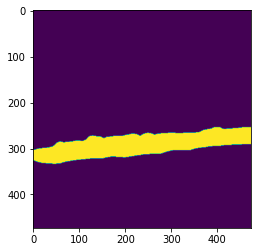

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
import cv2

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = downscale_image(np.array(cv2.imread(path)))
  sqwared = cv2.resize(img,(473,473),interpolation = cv2.INTER_AREA)
  cv2.imwrite("img_test.png",sqwared)
  out = load_model.predict_segmentation(inp=sqwared)
  sq_out = np.stack((out,)*3, axis=-1)
  new_arr = np.array(np.multiply(sqwared,sq_out))
  mask_img = cv2.resize(new_arr.astype(np.uint8),(550,550),interpolation = cv2.INTER_AREA)
  x = np.expand_dims(mask_img, axis=0)
  images = np.vstack([x])
  result = classifier_model.predict(images, batch_size=10)
  print(result)
  if result[0]<0.5:
    print(fn + " contains sidewalk")
  else:
    print(fn + " no sidewalk")


  plt.imshow(out)
